In [1]:
#Data Preprocessing
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction import text
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
df = pd.read_csv('BBC_train_full.csv')

# Load dataset
textData = df['text']

# Tokenize text
textData = textData.apply(word_tokenize)

# Remove stop words
stop = text.ENGLISH_STOP_WORDS

textData = textData.apply(lambda x: [word for word in x if word not in stop])

# Initialize stemmer
ps = PorterStemmer()

def stem_text(text):
    return [ps.stem(w) for w in text]

textData = textData.apply(stem_text)

#Initialize lemmatizer
wnl = WordNetLemmatizer()

def lemmatize_text(text):
    return [wnl.lemmatize(w) for w in text]

textData = textData.apply(lemmatize_text)

for i in textData:
    for j in i:
        i[i.index(j)] = j.strip(".,(){}[]+!-_?/ ") 
    i = filter(None, i)

# Clean text
textData = textData.apply(lambda x: ",".join(x))
textData = textData.apply(lambda x: x.replace(",", " "))

In [2]:
#convert data so that models can be trained
#create and train models (KNN and Random Forest)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

# Load and preprocess data, train and evaluate KNN model
le = preprocessing.LabelEncoder()

vectorizer = TfidfVectorizer(max_features=1000)
text_encoded = vectorizer.fit_transform(textData)

KNNmodel = KNeighborsClassifier(n_neighbors=135, p = 2)

label=le.fit_transform(df['category'])

X_train = text_encoded

Y_train = label

KNNmodel.fit(X_train,Y_train)

dfTest = pd.read_csv('test_data.csv')

test_encoded = vectorizer.transform(dfTest['text'])

dfLabels = pd.read_csv('test_labels.csv')

Y_test = le.transform(dfLabels['category'])

KNN_y_pred = KNNmodel.predict(test_encoded)

KNNaccuracy = accuracy_score(Y_test, KNN_y_pred)
print("KNN Accuracy:", KNNaccuracy)

KNN_report = classification_report(Y_test, KNN_y_pred)

print(KNN_report)

# Train and evaluate random forest model
RFmodel = RandomForestClassifier(n_estimators=100)

RFmodel.fit(X_train,Y_train)

RF_y_pred = RFmodel.predict(test_encoded)

RFaccuracy = accuracy_score(Y_test, RF_y_pred)
print("RF Accuracy:", RFaccuracy)

RF_report = classification_report(Y_test, RF_y_pred)

print(RF_report)

KNN Accuracy: 0.8717434869739479
              precision    recall  f1-score   support

           0       0.93      0.79      0.85        95
           1       0.95      0.88      0.92        94
           2       0.86      0.78      0.82       106
           3       0.93      0.97      0.95       115
           4       0.73      0.92      0.81        89

    accuracy                           0.87       499
   macro avg       0.88      0.87      0.87       499
weighted avg       0.88      0.87      0.87       499

RF Accuracy: 0.7915831663326653
              precision    recall  f1-score   support

           0       0.69      0.91      0.78        95
           1       0.75      0.91      0.83        94
           2       0.92      0.68      0.78       106
           3       0.79      0.99      0.88       115
           4       1.00      0.42      0.59        89

    accuracy                           0.79       499
   macro avg       0.83      0.78      0.77       499
weighted avg

In [6]:
#Split training into segments, train both models

In [3]:
#used to find n_neighbors value that gives highest accuracy

def findNNeigh(x_train, y_train):
    """
    Find the number of neighbors for KNN that gives the highest accuracy.

    Parameters:
    x_train (array-like): Training data features.
    y_train (array-like): Training data labels.

    Returns:
    int: The number of neighbors that gives the highest accuracy.
    """
    accuracy_test = 0
    winning_i = 0
    for i in range(1,x_train.shape[0]):
        model = KNeighborsClassifier(n_neighbors=i, p = 2)
        model.fit(x_train,y_train)
        KNN_pred = model.predict(test_encoded)
        accuracy = accuracy_score(Y_test, KNN_pred)
        if accuracy > accuracy_test:
            accuracy_test = accuracy
            winning_i = i
    return winning_i

    

In [4]:
#Steps:
#1) Concatenate train3 and X_train_100 (represents text)
#2) Concatenate train3_pred and Y_train_100 (represents labels)
#3) use these two new sets to fit KNNmodel_100
#4) predict using test_encoded (the testing data set representing text)
#5) measure accuracy using Y_test and findNNeigh(this value should be slightly higher than the previous accuracy value
# of KNNmodel_100 because half of its training data used mutual learning)
#6) Concatenate train3 and X_train_100_2
#7) Concatenate train3_pred and Y_train_100_2
#8) use these to fit KNNmodel_100_2
#9) predict using test_encoded
#10) measure accuracy using Y_test
#11) create a loop that creates a new subset of the training data set
#12) seperate this subset into text and labels
#13) use the two models to predict the text
#14) use the two models to find posterior probabilities (predict_proba) 
#15) use the loop to compare rows and create new label set
#16) start from step 1 above with the datasets we used for steps 11 - 15

In [5]:
#putting testing data segmentation and model training/mutual learning in loop

import scipy.sparse as sp # for sparse matrix
import numpy as np # for random.choice


# create two sets of 100 random indicies from X_train
row_indices_1 = np.random.choice(X_train.shape[0], 100, replace=False)
row_indices_2 = np.random.choice(X_train.shape[0], 100, replace=False)

# create subsets of text and label data from training set
X_train_100 = X_train[row_indices_1] #subset of text data from training set
Y_train_100 = Y_train[row_indices_1] #subset of label data from training set

X_train_100_2 = X_train[row_indices_2] #second subset of text data
Y_train_100_2 = Y_train[row_indices_2] #second subset of label data


# initialize variables to store accuracy values of KNN models
KNNaccuracy_100_graph = 0 # accuracy of KNN model #1 before mutual learning
KNNaccuracy_100_graph_2 = 0 # accuracy of KNN model #2 before mutual learning
KNNaccuracy_final = 0 # final accuracy after mutual learning

#create arrays to store accuracy values over the different rounds
KNNaccuracies_1 = []
KNNaccuracies_2 = []

for i in range(10):
    print("Round",i + 1,":")
    #train KNN models with the different subsets
    #use findNNeigh to get n_neighbors value with highest accuracy
    KNNmodel_100 = KNeighborsClassifier(n_neighbors=findNNeigh(X_train_100,Y_train_100), p = 2)
    KNNmodel_100.fit(X_train_100,Y_train_100)
    
    KNNmodel_100_2 = KNeighborsClassifier(n_neighbors=findNNeigh(X_train_100_2,Y_train_100_2), p = 2)
    KNNmodel_100_2.fit(X_train_100_2,Y_train_100_2)

    #test accuracy of both models against testing data set
    #these values should increase after mutual learning and will need to be plotted on line graph later
    KNN_y_pred_100 = KNNmodel_100.predict(test_encoded)
    KNNaccuracy_100 = accuracy_score(Y_test, KNN_y_pred_100)
    print("Accuracy of KNN Model #1:", KNNaccuracy_100)
    KNNaccuracies_1.append(KNNaccuracy_100)

    #assign KNNaccuracy_100_graph on first round of for loop
    if i == 0:
        KNNaccuracy_100_graph = KNNaccuracy_100

    if i == 9:
        KNNaccuracy_final = KNNaccuracy_100
    
    KNN_y_pred_100_2 = KNNmodel_100_2.predict(test_encoded)
    KNNaccuracy_100_2 = accuracy_score(Y_test, KNN_y_pred_100_2)
    print("Accuracy of KNN Model #2:", KNNaccuracy_100_2)
    KNNaccuracies_2.append(KNNaccuracy_100_2)

    if i == 0:
        KNNaccuracy_100_graph_2 = KNNaccuracy_100_2

    #mutual learning section
    #create another subset of training text data
    #this will be used in both models to create initial sets of labels
    row_indices_3 = np.random.choice(X_train.shape[0], 100, replace=False) 
    train3 = X_train[row_indices_3]

    # predict probabilities and labels for the new subset using both models
    train3_pred_proba = KNNmodel_100.predict_proba(train3)
    train3_pred = KNNmodel_100.predict(train3)

    train3_pred_proba_2 = KNNmodel_100_2.predict_proba(train3)
    train3_pred_2 = KNNmodel_100_2.predict(train3)

    #now that both models have produced labels, we can perform mutual learning
    #this loop cycles through the labels produced by both models, compares their posterior prob,
    #and reassigns the label of the lower scoring model with the label from the higher scoring model
    for i in range(100):
        if train3_pred_proba[i][train3_pred[i]] > train3_pred_proba_2[i][train3_pred_2[i]]:
            train3_pred_2[i] = train3_pred[i]
        elif train3_pred_proba_2[i][train3_pred_2[i]] > train3_pred_proba[i][train3_pred[i]]:
            train3_pred[i] = train3_pred_2[i]

    #now we have optimized labels that we can use to retrain both models, hopefully increasing accuracy
    #to retrain, concatenate train3 with X_train_100 then with X_train_100_2 (seperately)
    #use import scipy.sparse as sp (above)
    X_train_100 = sp.vstack([X_train_100,train3])
    X_train_100_2 = sp.vstack([X_train_100_2,train3])

    #now concatenate labels
    #technically, train3_pred and train3_pred_2 match, but for now im gonna use both for their
    #corresponding models
    Y_train_100 = np.concatenate((Y_train_100, train3_pred), axis=None)
    Y_train_100_2 = np.concatenate((Y_train_100_2, train3_pred_2), axis=None)
    #now the new X and Y sets can be used to retrain models, which will occur at beginning of loop   

Round 1 :
Accuracy of KNN Model #1: 0.781563126252505
Accuracy of KNN Model #2: 0.7735470941883767
Round 2 :
Accuracy of KNN Model #1: 0.7855711422845691
Accuracy of KNN Model #2: 0.8256513026052105
Round 3 :
Accuracy of KNN Model #1: 0.8176352705410822
Accuracy of KNN Model #2: 0.8296593186372746
Round 4 :
Accuracy of KNN Model #1: 0.8316633266533067
Accuracy of KNN Model #2: 0.845691382765531
Round 5 :
Accuracy of KNN Model #1: 0.8296593186372746
Accuracy of KNN Model #2: 0.8376753507014028
Round 6 :
Accuracy of KNN Model #1: 0.8336673346693386
Accuracy of KNN Model #2: 0.8416833667334669
Round 7 :
Accuracy of KNN Model #1: 0.8336673346693386
Accuracy of KNN Model #2: 0.8416833667334669
Round 8 :
Accuracy of KNN Model #1: 0.8376753507014028
Accuracy of KNN Model #2: 0.845691382765531
Round 9 :
Accuracy of KNN Model #1: 0.843687374749499
Accuracy of KNN Model #2: 0.8537074148296593
Round 10 :
Accuracy of KNN Model #1: 0.8517034068136272
Accuracy of KNN Model #2: 0.8597194388777555


In [7]:
#Repeat for two random forest models
#these are outside of loop because they are reassinged at bottom of loop
#create two sets of 100 random indicies from X_train
row_indices_1 = np.random.choice(X_train.shape[0], 100, replace=False)
row_indices_2 = np.random.choice(X_train.shape[0], 100, replace=False)

X_train_100 = X_train[row_indices_1] #subset of text data from training set
Y_train_100 = Y_train[row_indices_1] #subset of label data from training set

X_train_100_2 = X_train[row_indices_2] #second subset of text data
Y_train_100_2 = Y_train[row_indices_2] #second subset of label data

#create variable that represents accuracy of RF model trained with only 100 rows before mutual learning
RFaccuracy_100_graph = 0
RFaccuracy_100_graph_2 = 0
RFaccuracy_final = 0

#create arrays to store accuracy values over the different rounds
RFaccuracies_1 = []
RFaccuracies_2 = []

for i in range(10):
    print("Round",i + 1,":")
    #train random forest models with the different subsets
    RFmodel_100 = RandomForestClassifier(n_estimators=100)
    RFmodel_100.fit(X_train_100,Y_train_100)
    
    RFmodel_100_2 = RandomForestClassifier(n_estimators=100)
    RFmodel_100_2.fit(X_train_100_2, Y_train_100_2)

    #test accuracy of both models against testing data set
    #these values should increase after mutual learning and will need to be plotted on line graph later
    RF_y_pred_100 = RFmodel_100.predict(test_encoded)
    RFaccuracy_100 = accuracy_score(Y_test, RF_y_pred_100)
    print("Accuracy of RF Model #1:", RFaccuracy_100)
    RFaccuracies_1.append(RFaccuracy_100)
    #assign RFaccuracy_100_graph on first round of for loop
    if i == 0:
        RFaccuracy_100_graph = RFaccuracy_100
    if i == 9:
        RFaccuracy_final = RFaccuracy_100
    
    RF_y_pred_100_2 = RFmodel_100_2.predict(test_encoded)
    RFaccuracy_100_2 = accuracy_score(Y_test, RF_y_pred_100_2)
    print("Accuracy of RF Model #2:", RFaccuracy_100_2)
    RFaccuracies_2.append(RFaccuracy_100_2)
    if i == 0:
        RFaccuracy_100_graph_2 = RFaccuracy_100_2

    #mutual learning section
    #create another subset of training text data
    #this will be used in both models to create initial sets of labels
    row_indices_3 = np.random.choice(X_train.shape[0], 100, replace=False) 
    train3 = X_train[row_indices_3]

    train3_pred_proba = RFmodel_100.predict_proba(train3)
    train3_pred = RFmodel_100.predict(train3)

    train3_pred_proba_2 = RFmodel_100_2.predict_proba(train3)
    train3_pred_2 = RFmodel_100_2.predict(train3)

    #now that both models have produced labels, we can perform mutual learning
    #this loop cycles through the labels produced by both models, compares their posterior prob,
    #and reassigns the label of the lower scoring model with the label from the higher scoring model
    for i in range(100):
        if train3_pred_proba[i][train3_pred[i]] > train3_pred_proba_2[i][train3_pred_2[i]]:
            train3_pred_2[i] = train3_pred[i]
        elif train3_pred_proba_2[i][train3_pred_2[i]] > train3_pred_proba[i][train3_pred[i]]:
            train3_pred[i] = train3_pred_2[i]

    #now we have optimized labels that we can use to retrain both models, hopefully increasing accuracy
    #to retrain, concatenate train3 with X_train_100 then with X_train_100_2 (seperately)
    #use import scipy.sparse as sp (above)
    X_train_100 = sp.vstack([X_train_100,train3])
    X_train_100_2 = sp.vstack([X_train_100_2,train3])

    #now concatenate labels
    #technically, train3_pred and train3_pred_2 match, but for now im gonna use both for their
    #corresponding models
    Y_train_100 = np.concatenate((Y_train_100, train3_pred), axis=None)
    Y_train_100_2 = np.concatenate((Y_train_100_2, train3_pred_2), axis=None)
    #now the new X and Y sets can be used to retrain models, which will occur at beginning of loop

Round 1 :
Accuracy of RF Model #1: 0.5270541082164328
Accuracy of RF Model #2: 0.6052104208416834
Round 2 :
Accuracy of RF Model #1: 0.46893787575150303
Accuracy of RF Model #2: 0.5511022044088176
Round 3 :
Accuracy of RF Model #1: 0.6072144288577155
Accuracy of RF Model #2: 0.5851703406813628
Round 4 :
Accuracy of RF Model #1: 0.5891783567134269
Accuracy of RF Model #2: 0.6152304609218436
Round 5 :
Accuracy of RF Model #1: 0.5551102204408818
Accuracy of RF Model #2: 0.6052104208416834
Round 6 :
Accuracy of RF Model #1: 0.5951903807615231
Accuracy of RF Model #2: 0.6052104208416834
Round 7 :
Accuracy of RF Model #1: 0.5771543086172345
Accuracy of RF Model #2: 0.5771543086172345
Round 8 :
Accuracy of RF Model #1: 0.5751503006012024
Accuracy of RF Model #2: 0.593186372745491
Round 9 :
Accuracy of RF Model #1: 0.5811623246492986
Accuracy of RF Model #2: 0.5691382765531062
Round 10 :
Accuracy of RF Model #1: 0.5831663326653307
Accuracy of RF Model #2: 0.591182364729459


In [8]:
#repeat for KNN and random forest (heterogenous)
#create two sets of 100 random indicies from X_train
row_indices_1 = np.random.choice(X_train.shape[0], 100, replace=False)
row_indices_2 = np.random.choice(X_train.shape[0], 100, replace=False)

X_train_100 = X_train[row_indices_1] #subset of text data from training set
Y_train_100 = Y_train[row_indices_1] #subset of label data from training set

X_train_100_2 = X_train[row_indices_2] #second subset of text data
Y_train_100_2 = Y_train[row_indices_2] #second subset of label data

#create variable that represents accuracy of KNN model trained with only 100 rows before mutual learning
KNNaccuracy_100_graph_hetero = 0
RFaccuracy_100_graph_hetero = 0
KNNaccuracy_final_hetero = 0
RFaccuracy_final_hetero = 0

#create arrays to store accuracy values over the different rounds
KNNaccuracies_hetero = []
RFaccuracies_hetero = []

for i in range(10):
    print("Round",i + 1,":")
    #train KNN models with the different subsets
    #use findNNeigh to get n_neighbors value with highest accuracy
    KNNmodel_100_hetero = KNeighborsClassifier(n_neighbors=findNNeigh(X_train_100,Y_train_100), p = 2)
    KNNmodel_100_hetero.fit(X_train_100,Y_train_100)
    
    RFmodel_100_hetero = RandomForestClassifier(n_estimators=100)
    RFmodel_100_hetero.fit(X_train_100_2,Y_train_100_2)

    #test accuracy of both models against testing data set
    #these values should increase after mutual learning and will need to be plotted on line graph later
    KNN_y_pred_100_hetero = KNNmodel_100_hetero.predict(test_encoded)
    KNNaccuracy_100_hetero = accuracy_score(Y_test, KNN_y_pred_100_hetero)
    print("Accuracy of KNN Model:", KNNaccuracy_100_hetero)
    KNNaccuracies_hetero.append(KNNaccuracy_100_hetero)
    #assign KNNaccuracy_100_graph on first round of for loop
    if i == 0:
        KNNaccuracy_100_graph_hetero = KNNaccuracy_100_hetero

    if i == 9:
        KNNaccuracy_final_hetero = KNNaccuracy_100_hetero
    
    RF_y_pred_100_hetero = RFmodel_100_hetero.predict(test_encoded)
    RFaccuracy_100_hetero = accuracy_score(Y_test, RF_y_pred_100_hetero)
    print("Accuracy of RF Model:", RFaccuracy_100_hetero)
    RFaccuracies_hetero.append(RFaccuracy_100_hetero)
    if i == 0:
        RFaccuracy_100_graph_hetero = RFaccuracy_100_hetero
    if i == 9:
        RFaccuracy_final_hetero = RFaccuracy_100_hetero

    #mutual learning section
    #create another subset of training text data
    #this will be used in both models to create initial sets of labels
    row_indices_3 = np.random.choice(X_train.shape[0], 100, replace=False) 
    train3 = X_train[row_indices_3]

    train3_pred_proba = KNNmodel_100_hetero.predict_proba(train3)
    train3_pred = KNNmodel_100_hetero.predict(train3)

    train3_pred_proba_2 = RFmodel_100_hetero.predict_proba(train3)
    train3_pred_2 = RFmodel_100_hetero.predict(train3)

    #now that both models have produced labels, we can perform mutual learning
    #this loop cycles through the labels produced by both models, compares their posterior prob,
    #and reassigns the label of the lower scoring model with the label from the higher scoring model
    for i in range(100):
        if train3_pred_proba[i][train3_pred[i]] > train3_pred_proba_2[i][train3_pred_2[i]]:
            train3_pred_2[i] = train3_pred[i]
        elif train3_pred_proba_2[i][train3_pred_2[i]] > train3_pred_proba[i][train3_pred[i]]:
            train3_pred[i] = train3_pred_2[i]

    #now we have optimized labels that we can use to retrain both models, hopefully increasing accuracy
    #to retrain, concatenate train3 with X_train_100 then with X_train_100_2 (seperately)
    #use import scipy.sparse as sp (above)
    X_train_100 = sp.vstack([X_train_100,train3])
    X_train_100_2 = sp.vstack([X_train_100_2,train3])

    #now concatenate labels
    #technically, train3_pred and train3_pred_2 match, but for now im gonna use both for their
    #corresponding models
    Y_train_100 = np.concatenate((Y_train_100, train3_pred), axis=None)
    Y_train_100_2 = np.concatenate((Y_train_100_2, train3_pred_2), axis=None)
    #now the new X and Y sets can be used to retrain models, which will occur at beginning of loop

Round 1 :
Accuracy of KNN Model: 0.7995991983967936
Accuracy of RF Model: 0.46292585170340683
Round 2 :
Accuracy of KNN Model: 0.8056112224448898
Accuracy of RF Model: 0.6172344689378757
Round 3 :
Accuracy of KNN Model: 0.7935871743486974
Accuracy of RF Model: 0.6693386773547094
Round 4 :
Accuracy of KNN Model: 0.8176352705410822
Accuracy of RF Model: 0.6633266533066132
Round 5 :
Accuracy of KNN Model: 0.8216432865731463
Accuracy of RF Model: 0.7214428857715431
Round 6 :
Accuracy of KNN Model: 0.8276553106212425
Accuracy of RF Model: 0.7254509018036072
Round 7 :
Accuracy of KNN Model: 0.8216432865731463
Accuracy of RF Model: 0.7474949899799599
Round 8 :
Accuracy of KNN Model: 0.8396793587174348
Accuracy of RF Model: 0.7374749498997996
Round 9 :
Accuracy of KNN Model: 0.845691382765531
Accuracy of RF Model: 0.7354709418837675
Round 10 :
Accuracy of KNN Model: 0.8496993987975952
Accuracy of RF Model: 0.749498997995992


In [9]:
# Data Visualization

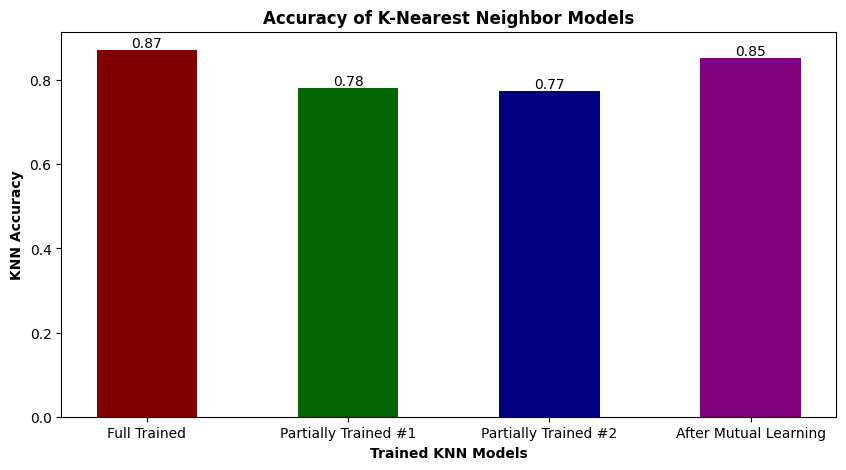

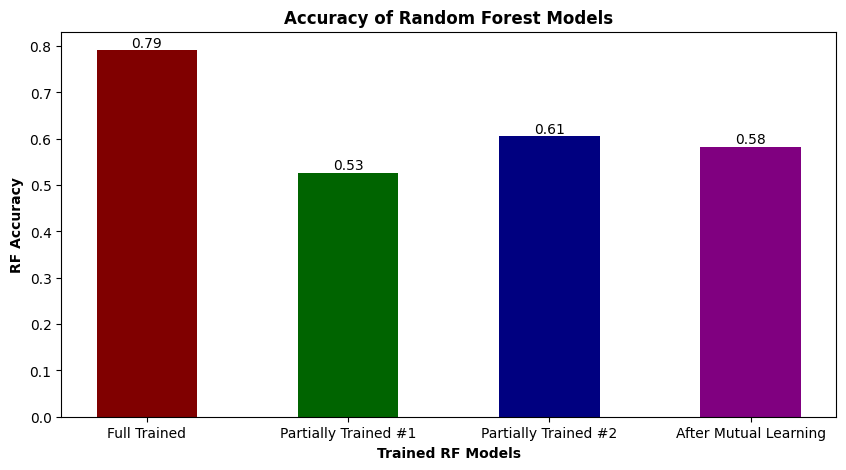

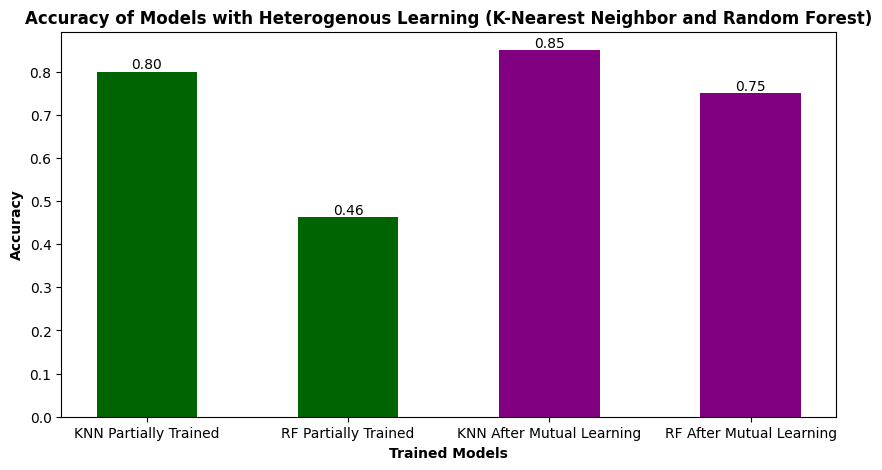

In [10]:
import numpy as np
import matplotlib.pyplot as plt 

#visualization for KNN 
# creating the dataset
dataKNN = {'Full Trained':KNNaccuracy,'Partially Trained #1':KNNaccuracy_100_graph, 'Partially Trained #2':KNNaccuracy_100_graph_2,'After Mutual Learning':KNNaccuracy_final}
modelsKNN = list(dataKNN.keys())
accuraciesKNN = list(dataKNN.values())
 
figKNN = plt.figure(figsize = (10, 5))

# creating the bar plot
colors = ['maroon', 'darkgreen', 'navy','purple']
bars = plt.bar(modelsKNN, accuraciesKNN, color =colors, 
        width = 0.5)
plt.bar_label(bars,fmt='%.2f')

plt.xlabel("Trained KNN Models",fontweight='bold')
plt.ylabel("KNN Accuracy",fontweight='bold')
plt.title("Accuracy of K-Nearest Neighbor Models",fontweight='bold')
plt.show()

#visualization for RF
dataRF = {'Full Trained':RFaccuracy,'Partially Trained #1':RFaccuracy_100_graph, 'Partially Trained #2':RFaccuracy_100_graph_2, 'After Mutual Learning':RFaccuracy_final}
modelsRF = list(dataRF.keys())
accuraciesRF = list(dataRF.values())
 
figRF = plt.figure(figsize = (10, 5))

# creating the bar plot
colors = ['maroon', 'darkgreen', 'navy','purple']
bars = plt.bar(modelsRF, accuraciesRF, color =colors, 
        width = 0.5)
plt.bar_label(bars,fmt='%.2f')
plt.xlabel("Trained RF Models",fontweight='bold')
plt.ylabel("RF Accuracy",fontweight='bold')
plt.title("Accuracy of Random Forest Models",fontweight='bold')
plt.show()

#visualization for hetero learning
dataHetero = {'KNN Partially Trained':KNNaccuracy_100_graph_hetero,'RF Partially Trained':RFaccuracy_100_graph_hetero, 'KNN After Mutual Learning':KNNaccuracy_final_hetero, 'RF After Mutual Learning':RFaccuracy_final_hetero}
modelsHetero = list(dataHetero.keys())
accuraciesHetero = list(dataHetero.values())
 
figHetero = plt.figure(figsize = (10, 5))

# creating the bar plot
colors = ['darkgreen', 'darkgreen', 'purple','purple']
bars = plt.bar(modelsHetero, accuraciesHetero, color =colors, 
        width = 0.5)
plt.bar_label(bars,fmt='%.2f')
plt.xlabel("Trained Models",fontweight='bold')
plt.ylabel("Accuracy",fontweight='bold')
plt.title("Accuracy of Models with Heterogenous Learning (K-Nearest Neighbor and Random Forest)",fontweight='bold')
plt.show()



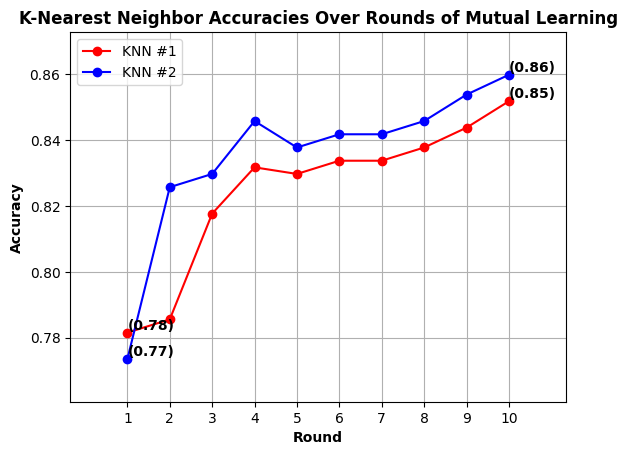

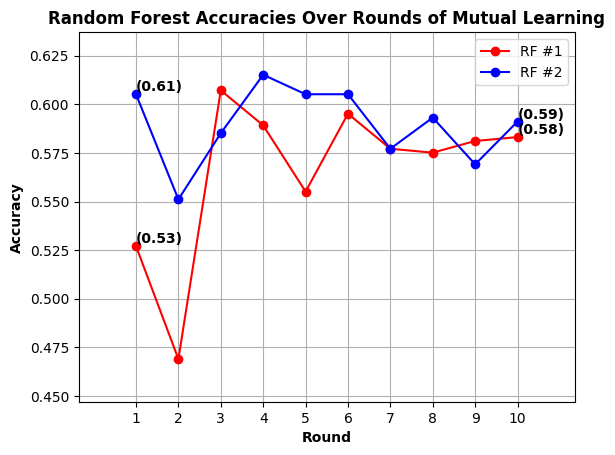

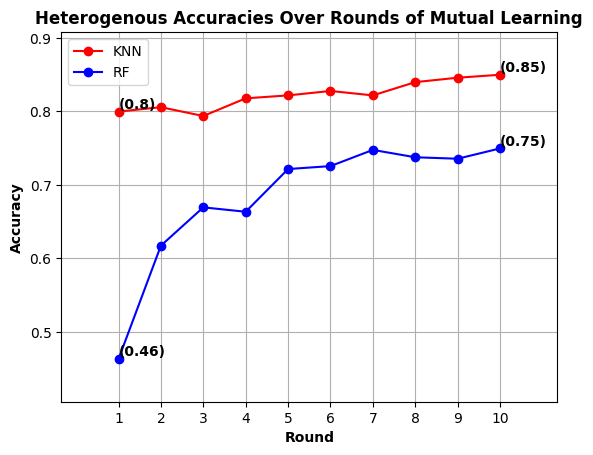

In [11]:
#creating line graph for RF homogenous learning
#x represents the number of rounds
x = [1,2,3,4,5,6,7,8,9,10]
#plt.figure(figsize = (12, 5))
#y will be the accuracy arrays creating in each set of mutual learning
plt.plot(x, KNNaccuracies_1, color = 'red',marker='o')
plt.plot(x, KNNaccuracies_2, color = 'blue',marker='o')
plt.margins(x=0.15,y=0.15)
plt.text(x[0], KNNaccuracies_1[0], f'({round(KNNaccuracies_1[0],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[0], KNNaccuracies_2[0], f'({round(KNNaccuracies_2[0],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[-1], KNNaccuracies_1[-1], f'({round(KNNaccuracies_1[-1],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[-1], KNNaccuracies_2[-1], f'({round(KNNaccuracies_2[-1],2)})', ha='left', va='bottom',fontweight='bold')
plt.grid(True)
plt.xticks(x)
plt.xlabel('Round',fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('K-Nearest Neighbor Accuracies Over Rounds of Mutual Learning',fontweight='bold')
plt.legend(['KNN #1', 'KNN #2'])
plt.show()

#creating line graph for RF homogenous learning
plt.plot(x, RFaccuracies_1, color = 'red',marker='o')
plt.plot(x, RFaccuracies_2, color = 'blue',marker='o')
plt.margins(x=0.15,y=0.15)
plt.text(x[0], RFaccuracies_1[0], f'({round(RFaccuracies_1[0],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[0], RFaccuracies_2[0], f'({round(RFaccuracies_2[0],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[-1], RFaccuracies_1[-1], f'({round(RFaccuracies_1[-1],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[-1], RFaccuracies_2[-1], f'({round(RFaccuracies_2[-1],2)})', ha='left', va='bottom',fontweight='bold')
plt.grid(True)
plt.xticks(x)
plt.xlabel('Round',fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Random Forest Accuracies Over Rounds of Mutual Learning',fontweight='bold')
plt.legend(['RF #1', 'RF #2'])
plt.show()

#creating line graph for heterogenous learning
plt.plot(x, KNNaccuracies_hetero, color = 'red',marker='o')
plt.plot(x, RFaccuracies_hetero, color = 'blue',marker='o')
plt.margins(x=0.15,y=0.15)
plt.text(x[0], KNNaccuracies_hetero[0], f'({round(KNNaccuracies_hetero[0],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[0], RFaccuracies_hetero[0], f'({round(RFaccuracies_hetero[0],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[-1], KNNaccuracies_hetero[-1], f'({round(KNNaccuracies_hetero[-1],2)})', ha='left', va='bottom',fontweight='bold')
plt.text(x[-1], RFaccuracies_hetero[-1], f'({round(RFaccuracies_hetero[-1],2)})', ha='left', va='bottom',fontweight='bold')
plt.grid(True)
plt.xticks(x)
plt.xlabel('Round',fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Heterogenous Accuracies Over Rounds of Mutual Learning',fontweight='bold')
plt.legend(['KNN', 'RF'])
plt.show()